# Semantic segmentation test

---

**Author:** [rodoart](https://github.com/rodoart/)<br>
**Date created:** 2020/07/19<br>
**Last modified:** 2021/07/19<br>
**Description:** 
Example of a network to create bounding boxes and label, based on [Divam Gupta (2019)](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html)

# A Beginner's guide to Deep Learning based Semantic Segmentation using Keras

## Path config

If you want the files to be copied to another folder within the same machine you are working on, by a source path other than remote.

In [1]:
PROJECT_SLUG = 'vigilancia_mascotas'
NAME = 'semantic_segmentation_test'
NUMBER = '0.0'


NOTEBOOK_NAME = f'{NUMBER}-{PROJECT_SLUG}-{NAME}.ipynb'

# COLAB
#DRIVE_MOUNT = '/drive'
#REMOTE_PATH = f'{DRIVE_MOUNT}/MyDrive/proyects/{PROJECT_SLUG}'
#LOCAL_PATH = '.'
#NOTEBOOK_PATH = f'{DRIVE_MOUNT}/MyDrive/Colab Notebooks/{NOTEBOOK_NAME}'

# LOCAL
REMOTE_PATH = '..'
LOCAL_PATH = '..'
DRIVE_MOUNT = ''
NOTEBOOK_PATH = f'G:\\Mi unidad\\Colab Notebooks\\{NOTEBOOK_NAME}'

In [2]:
if DRIVE_MOUNT:
    from google.colab import drive
    drive.mount(DRIVE_MOUNT)
    to_remote = True
else:
    to_remote = False

## Path functions

In [3]:
import sys

# It depends on where the library that comes with this package is stored.
sys.path.append(REMOTE_PATH)

In [4]:
from vigilancia_mascotas.utils.paths \
    import make_remote_copy_of_workspace_functions

In [5]:
local_dir, update_from_remote, update_to_remote, update_notebook = \
    make_remote_copy_of_workspace_functions(
        local_path=LOCAL_PATH,
        remote_path=REMOTE_PATH,
        notebook_path = NOTEBOOK_PATH
    )

## Update local folders

In [ ]:
update_from_remote()

There is no need to copy the remote files, as the remote repository does not exist or is empty.


## Implementation

We will be using Keras for building and training the segmentation models. First, install `keras_segmentation` which contains all the utilities required.

## Dataset

The first step in training our segmentation model is to prepare the dataset. We would need the input RGB images and the corresponding segmentation images. If you want to make your own dataset, a tool like [labelme](https://github.com/wkentaro/labelme) or [GIMP](https://www.gimp.org/) can be used to manually generate the ground truth segmentation masks.

Assign each class a unique ID. In the segmentation images, the pixel value should denote the class ID of the corresponding pixel. This is a common format used by most of the datasets and `keras_segmentation`. For the segmentation maps, do not use the `jpg` format as `jpg` is lossy and the pixel values might change. Use `bmp` or png format instead. And of course, the size of the input image and the segmentation image should be the same.

In the following example, pixel (0,0) is labeled as class 2, pixel (3,4) is labeled as class 1 and rest of the pixels are labeled as class 0.

In [6]:
from os import makedirs

In [7]:
ann_1_path = local_dir('data', 'processed', 'semantic_segmentation', 
                       'ann_1.png')

In [8]:
makedirs(ann_1_path.parent, exist_ok=True)

In [9]:
import cv2
import numpy as np

ann_img = np.zeros((30,30,3)).astype('uint8')
ann_img[ 3 , 4 ] = 1 # this would set the label of pixel 3,4 as 1
ann_img[ 0 , 0 ] = 2 # this would set the label of pixel 0,0 as 2

cv2.imwrite(str(ann_1_path), ann_img)

True

After generating the segmentation images, place them in the training/testing folder. Make separate folders for input images and the segmentation images. The file name of the input image and the corresponding segmentation image should be the same.

Refer to the format below :

```
dataset/
	train_images/
		- img0001.png
		- img0002.png
		- img0003.png
	train_segmentation/
		- img0001.png
		- img0002.png
		- img0003.png
	val_images/
		- img0004.png
		- img0005.png
		- img0006.png
	val_segmentation/
		- img0004.png
		- img0005.png
		- img0006.png

```

### Download and unzip the example dataset

You can refer to a sample dataset [here](https://github.com/divamgupta/image-segmentation-keras/tree/master/test/example_dataset).


For this tutorial we would be using a data-set which is already prepared. You can download it from [here](https://drive.google.com/file/d/0B0d9ZiqAgFkiOHR1NTJhWVJMNEU/view?usp=sharing).

In [12]:
import gdown

In [13]:
file_id = '0B0d9ZiqAgFkiOHR1NTJhWVJMNEU'
zip_path = local_dir('tmp', 'semantic_segmentation', 'dataset1.zip')
dataset_path = local_dir('data', 'raw', 'semantic_segmentation')

makedirs(zip_path.parent, exist_ok=True)
makedirs(dataset_path, exist_ok=True)

In [14]:
if not dataset_path.is_dir() and not zip_path.is_file():
    url_gdown = f'https://drive.google.com/u/0/uc?id={file_id}'
    gdown.download(url_gdown, str(zip_path), quiet=False)

In [15]:
import zipfile
if not dataset_path.is_dir():
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)

### Rename folders

In [16]:
from os import rename

In [17]:
dataset1_path = dataset_path.joinpath('dataset1')

train_images_path = dataset1_path.joinpath('train_images')
train_segmentation_path = dataset1_path.joinpath('train_segmentation')

val_images_path = dataset1_path.joinpath('val_images')
val_segmentation_path = dataset1_path.joinpath('val_segmentation')

old_train_images_path = dataset1_path.joinpath('images_prepped_train')
old_train_segmentation_path =dataset1_path.joinpath('annotations_prepped_train')

old_val_images_path = dataset1_path.joinpath('images_prepped_test')
old_val_segmentation_path = dataset1_path.joinpath('annotations_prepped_test')

In [19]:
for dst, src in zip(
    [train_images_path, train_segmentation_path, val_images_path,
    val_segmentation_path],
    [old_train_images_path, old_train_segmentation_path, old_val_images_path,
    old_val_segmentation_path],
):

    try:
        rename(src, dst)
    except Exception as e:
        pass

## Data Augmentation

If you have less number of training pairs, the results might not be good be because the model might overfit. We can increase the size of the dataset by applying random transformations on the images. We can change the color properties like hue, saturation, brightness, etc of the input images. We can also apply transformations such as rotation, scale, and flipping. For the transformations which change the location of the pixels, the segmentation image should also be transformed the same way.

In [20]:
import imgaug as ia
import imgaug.augmenters as iaa

In [21]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

In [22]:
def augment_seg( img , seg  ):
	
	aug_det = seq.to_deterministic() 
	image_aug = aug_det.augment_image( img )

	segmap = ia.SegmentationMapOnImage( seg , nb_classes=np.max(seg)+1 , shape=img.shape )
	segmap_aug = aug_det.augment_segmentation_maps( segmap )
	segmap_aug = segmap_aug.get_arr_int()

	return image_aug , segmap_aug

Here `aug_det` defines the parameters of the transformation, which is applied both to input image `img` and the segmentation image `seg`.

After preparing the dataset, you might want to verify it and also visualize it.

In [23]:
from IPython.display import Markdown as md

In [24]:
md(
    "```shell \n"
   +"python -m keras_segmentation verify_dataset "
   +f'--images_path="{train_images_path}" '
   +f'--segs_path="{train_segmentation_path}" '
   +'--n_classes=50\n'
   +'```'    
)

```shell 
python -m keras_segmentation verify_dataset --images_path="G:\Mi unidad\IA\seminario_innovacion\vigilancia_mascotas\data\raw\semantic_segmentation\dataset1\train_images" --segs_path="G:\Mi unidad\IA\seminario_innovacion\vigilancia_mascotas\data\raw\semantic_segmentation\dataset1\train_segmentation" --n_classes=50
```

In [25]:
md(
    "```shell \n"
   +"python -m keras_segmentation visualize_dataset "
   +f'--images_path="{train_images_path}" '
   +f'--segs_path="{train_segmentation_path}" '
   +'--n_classes=50\n'
   +'```'    
)

```shell 
python -m keras_segmentation visualize_dataset --images_path="G:\Mi unidad\IA\seminario_innovacion\vigilancia_mascotas\data\raw\semantic_segmentation\dataset1\train_images" --segs_path="G:\Mi unidad\IA\seminario_innovacion\vigilancia_mascotas\data\raw\semantic_segmentation\dataset1\train_segmentation" --n_classes=50
```

## Pre-trained models


Now, let’s use the Keras API to define our segmentation model with skip connections.

Let’s define the encoder layers. Here, each block contains two convolution layers and one max pooling layer which would downsample the image by a factor of two.

In [27]:
from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12

model = pspnet_50_ADE_20K() # load the pretrained model trained on ADE20k dataset

#model = pspnet_101_cityscapes() # load the pretrained model trained on Cityscapes dataset

#model = pspnet_101_voc12() # load the pretrained model trained on Pascal VOC 2012 dataset

In [28]:
from os import listdir

In [36]:
file_name = listdir(val_images_path)[0]
image_input = val_images_path.joinpath(file_name)
image_output = local_dir('data', 'processed', 'semantic_segmentation', 
                         'dataset1', 'predict_segmentation', file_name)


WindowsPath('G:/Mi unidad/IA/seminario_innovacion/vigilancia_mascotas/data/processed/semantic_segmentation/dataset1/predict_segmentation/0016E5_08085.png')

In [37]:
makedirs(image_output.parent, exist_ok=True)

In [39]:
out = model.predict_segmentation(
    inp=str(image_input),
    out_fname=str(image_output)
)

Show result.

In [45]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


In [ ]:
plt.fig

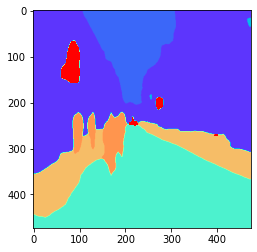

In [65]:
plt.imshow(
    out, 
    cmap='rainbow', 
    norm=Normalize(vmin=0, vmax=15, clip=True)
)

In [68]:
import matplotlib.image as mpimg

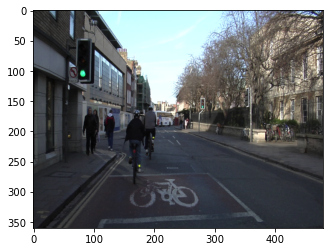

In [69]:
input = mpimg.imread(str(image_input))
plt.imshow(
    input
)

## Evaluating the model

In [71]:
print(model.evaluate_segmentation(
                inp_images_dir = str(val_images_path),
                annotations_dir =  str(val_segmentation_path)  
        )
)

101it [12:53,  7.65s/it]

{'frequency_weighted_IU': 0.15168358610312402, 'mean_IU': 0.004140151792532021, 'class_wise_IU': array([0.00000000e+00, 5.79505112e-01, 3.06218689e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.15145951e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+

## Update remote folders

In [18]:
update_notebook(to_remote)

The notebook 0.0-vigilancia_mascotas-semantic_segmentation_test.ipynb has been updated in the remote folder


In [19]:
update_to_remote()